In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import os
os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "2")  # Report only TF errors by default

2023-11-26 17:29:25.242712: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


'1'

In [2]:
import matplotlib.pyplot as plt
import missingno
import nltk
from nltk.tokenize import RegexpTokenizer
import numpy as np
import pandas as pd
from pathlib import Path
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

In [3]:
SEED = 42
BATCH_SIZE = 8

tf.keras.utils.set_random_seed(SEED)

In [4]:
dataset_path = Path("./leetcode_dataset.csv")

if dataset_path.exists():
    df = pd.read_csv("./leetcode_dataset.csv")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 1825 non-null   int64  
 1   title              1825 non-null   object 
 2   description        1825 non-null   object 
 3   is_premium         1825 non-null   int64  
 4   difficulty         1825 non-null   object 
 5   solution_link      987 non-null    object 
 6   acceptance_rate    1825 non-null   float64
 7   frequency          1825 non-null   float64
 8   url                1825 non-null   object 
 9   discuss_count      1825 non-null   int64  
 10  accepted           1825 non-null   object 
 11  submissions        1825 non-null   object 
 12  companies          1749 non-null   object 
 13  related_topics     1571 non-null   object 
 14  likes              1825 non-null   int64  
 15  dislikes           1825 non-null   int64  
 16  rating             1825 

In [6]:
df = df.drop(columns=["is_premium", "solution_link", "url", "companies", "asked_by_faang", "frequency"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 1825 non-null   int64  
 1   title              1825 non-null   object 
 2   description        1825 non-null   object 
 3   difficulty         1825 non-null   object 
 4   acceptance_rate    1825 non-null   float64
 5   discuss_count      1825 non-null   int64  
 6   accepted           1825 non-null   object 
 7   submissions        1825 non-null   object 
 8   related_topics     1571 non-null   object 
 9   likes              1825 non-null   int64  
 10  dislikes           1825 non-null   int64  
 11  rating             1825 non-null   int64  
 12  similar_questions  745 non-null    object 
dtypes: float64(1), int64(5), object(7)
memory usage: 185.5+ KB


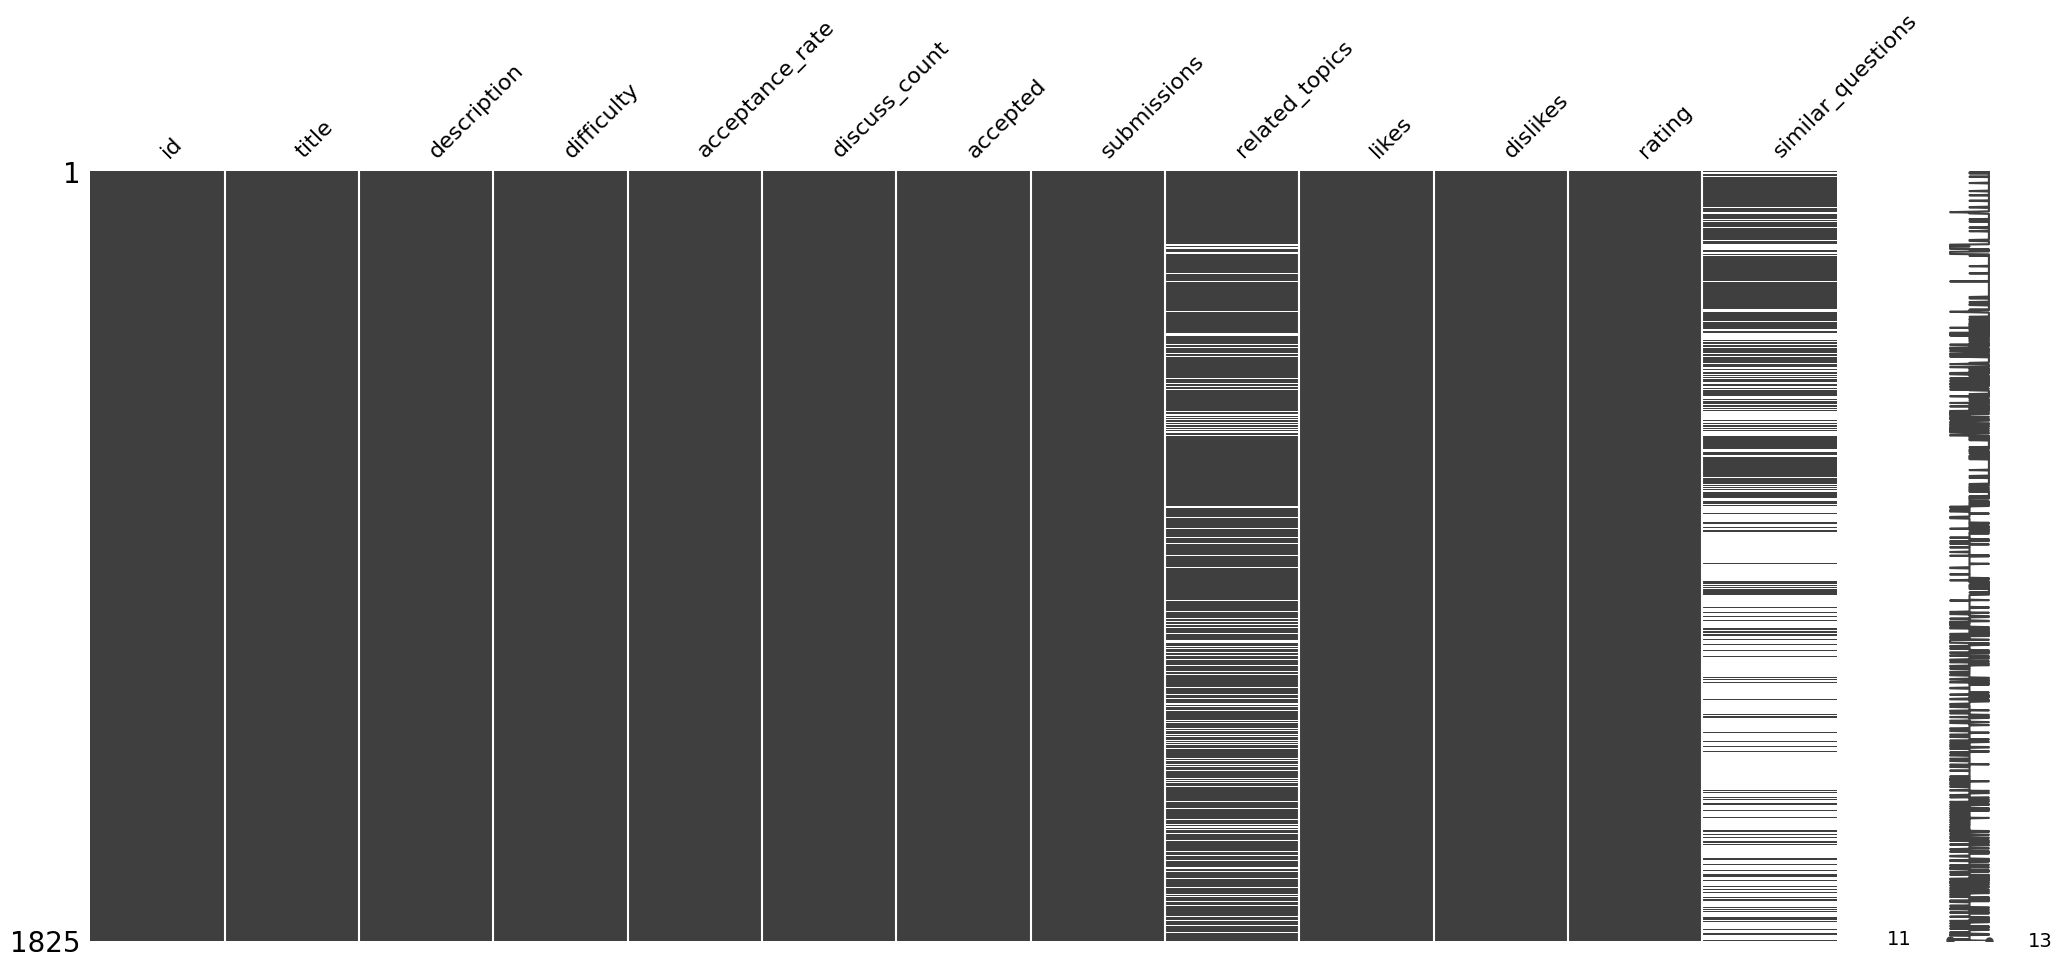

In [7]:
missingno.matrix(df)
plt.show()

In [8]:
df_numerical, df_categorical = df.select_dtypes([np.number]), df.select_dtypes([object])
print(f'Number of numerical features: {len(df_numerical.T)}')
print(f'Number of categorical features: {len(df_categorical.T)}')

Number of numerical features: 6
Number of categorical features: 7


In [9]:
df.head()

,id,title,description,difficulty,acceptance_rate,discuss_count,accepted,submissions,related_topics,likes,dislikes,rating,similar_questions
0,1,Two Sum,Given an array of integers `nums` and an integ...,Easy,46.7,999,4.1M,8.7M,"Array,Hash Table",20217,712,97,"[3Sum, /problems/3sum/, Medium], [4Sum, /probl..."
1,2,Add Two Numbers,You are given two non-empty linked lists repre...,Medium,35.7,999,1.9M,5.2M,"Linked List,Math,Recursion",11350,2704,81,"[Multiply Strings, /problems/multiply-strings/..."
2,3,Longest Substring Without Repeating Characters,"Given a string `s`, find the length of the lon...",Medium,31.5,999,2.1M,6.7M,"Hash Table,Two Pointers,String,Sliding Window",13810,714,95,[Longest Substring with At Most Two Distinct C...
3,4,Median of Two Sorted Arrays,Given two sorted arrays `nums1` and `nums2` of...,Hard,31.4,999,904.7K,2.9M,"Array,Binary Search,Divide and Conquer",9665,1486,87,NaN
4,5,Longest Palindromic Substring,"Given a string `s`, return the longest palindr...",Medium,30.6,999,1.3M,4.1M,"String,Dynamic Programming",10271,670,94,"[Shortest Palindrome, /problems/shortest-palin..."


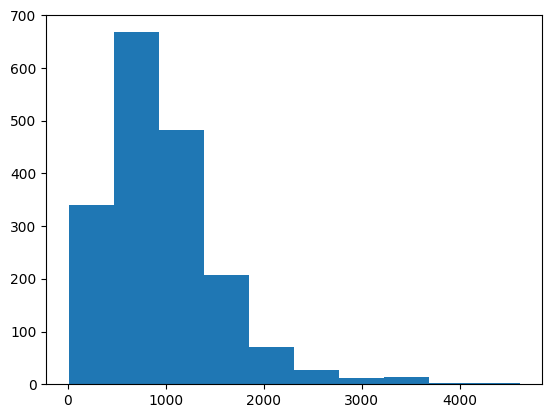

In [10]:
description_sizes = list(map(lambda d: len(d), df["description"].values))

plt.hist(description_sizes, bins=10)
plt.show()

In [11]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
def strip_examples(description):
    if "Example 1" not in description:
        return description
    
    return description[:description.index("Example 1")]

# remove examples
df["stripped description"] = df["description"].apply(lambda d: strip_examples(d))
corpus = df["stripped description"].values
# remove numbers
corpus = list(map(lambda s: ''.join([char for char in s if not char.isdigit()]), corpus))

en_stopwords = nltk.corpus.stopwords.words("english")
vectorizer = TfidfVectorizer(stop_words=en_stopwords, ngram_range=(1,1))
vectorizer.fit(corpus)

TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])

In [13]:
tf_idf_descriptions = vectorizer.transform(df["stripped description"].values)
tf_idf_descriptions.shape

(1825, 4750)

In [14]:
numerical_difficulties = { "Easy": 0, "Medium": 1, "Hard": 2 }

X, y = [], []
for tokenized_description, difficulty in zip(tf_idf_descriptions, df["difficulty"].values):
    X.append(tokenized_description.toarray()[0].tolist())
    y.append(numerical_difficulties[difficulty])

In [15]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y),
    y=y
)

class_weight_dict = {i : class_weights[i] for i in range(len(class_weights))}
class_weight_dict

{0: 1.2753319357092943, 1: 0.6317064728279681, 2: 1.58008658008658}

In [16]:
N = len(X)
TRAIN_SIZE = int(N * 0.8)
VALIDATION_SIZE = N - TRAIN_SIZE

print(f'{TRAIN_SIZE=}, {VALIDATION_SIZE=}')

features_dataset = tf.data.Dataset.from_tensor_slices(X)
target_dataset = tf.data.Dataset.from_tensor_slices(y)
combined_dataset = tf.data.Dataset.zip((features_dataset, target_dataset))

TRAIN_SIZE=1460, VALIDATION_SIZE=365


2023-11-26 17:29:43.350695: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7970 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 1g.10gb, pci bus id: 0000:21:00.0, compute capability: 8.0


In [17]:
train = combined_dataset.take(TRAIN_SIZE).batch(BATCH_SIZE).shuffle(TRAIN_SIZE, seed=SEED).prefetch(tf.data.AUTOTUNE)
validation = combined_dataset.skip(TRAIN_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [37]:
input = tf.keras.layers.Input(shape=(None, tf_idf_descriptions.shape[1]))

hidden1 = tf.keras.layers.Dense(
    units=512,
    activation=tf.nn.relu,
    kernel_regularizer=tf.keras.regularizers.l2(0.02)
)(input)
dropout1 = tf.keras.layers.Dropout(
    0.7
)(hidden1)

output = tf.keras.layers.Dense(
    units=3,
    activation=tf.nn.softmax
)(dropout1)

mlp = tf.keras.models.Model(inputs=input, outputs=output, name="mlp")

mlp.compile(
    optimizer=tf.optimizers.Adam(jit_compile=False, learning_rate=0.005),
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.metrics.SparseCategoricalAccuracy("sparseCatAcc")]
)

In [38]:
mlp.summary()

Model: "mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, None, 4750)]      0         
                                                                 
 dense_18 (Dense)            (None, None, 512)         2432512   
                                                                 
 dropout_11 (Dropout)        (None, None, 512)         0         
                                                                 
 dense_19 (Dense)            (None, None, 3)           1539      
                                                                 
Total params: 2,434,051
Trainable params: 2,434,051
Non-trainable params: 0
_________________________________________________________________


In [39]:
mlp.fit(
    train,
    epochs=20,
    class_weight=class_weight_dict,
    callbacks=[
        tf.keras.callbacks.TensorBoard('./models/logs/mlp'),
        tf.keras.callbacks.ModelCheckpoint(
            filepath='./models/mlp_{epoch}.h5',
            monitor='val_loss',
            mode='min',
            save_best_only=True,
            verbose=1
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            mode='min',
            patience=3,
            verbose=1,
            restore_best_weights=True
        )
    ],
    validation_data=validation
)

Epoch 1/20


2023-11-26 17:36:13.710985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [1825,4750]
	 [[{{node Placeholder/_0}}]]
2023-11-26 17:36:13.711417: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int32 and shape [1825]
	 [[{{node Placeholder/_2}}]]


180/183 [============================>.] - ETA: 0s - loss: 1.6597 - sparseCatAcc: 0.3875
Epoch 1: val_loss improved from inf to 1.29364, saving model to ./models/mlp_1.h5
183/183 [==============================] - 1s 5ms/step - loss: 1.6553 - sparseCatAcc: 0.3836 - val_loss: 1.2936 - val_sparseCatAcc: 0.3096
Epoch 2/20
176/183 [===========================>..] - ETA: 0s - loss: 1.2624 - sparseCatAcc: 0.3561
Epoch 2: val_loss improved from 1.29364 to 1.22504, saving model to ./models/mlp_2.h5
183/183 [==============================] - 1s 5ms/step - loss: 1.2607 - sparseCatAcc: 0.3568 - val_loss: 1.2250 - val_sparseCatAcc: 0.4767
Epoch 3/20
172/183 [===========================>..] - ETA: 0s - loss: 1.2254 - sparseCatAcc: 0.3805
Epoch 3: val_loss did not improve from 1.22504
183/183 [==============================] - 1s 5ms/step - loss: 1.2288 - sparseCatAcc: 0.3747 - val_loss: 1.2448 - val_sparseCatAcc: 0.2685
Epoch 4/20
177/183 [============================>.] - ETA: 0s - loss: 1.2187 - 

In [40]:
mlp.predict(validation)

46/46 [==============================] - 0s 841us/step


array([[0.3248826 , 0.34618732, 0.3289301 ],
       [0.3248826 , 0.34618732, 0.3289301 ],
       [0.3248826 , 0.34618732, 0.3289301 ],
       ...,
       [0.3248826 , 0.34618732, 0.3289301 ],
       [0.3248826 , 0.34618732, 0.3289301 ],
       [0.3248826 , 0.34618732, 0.3289301 ]], dtype=float32)